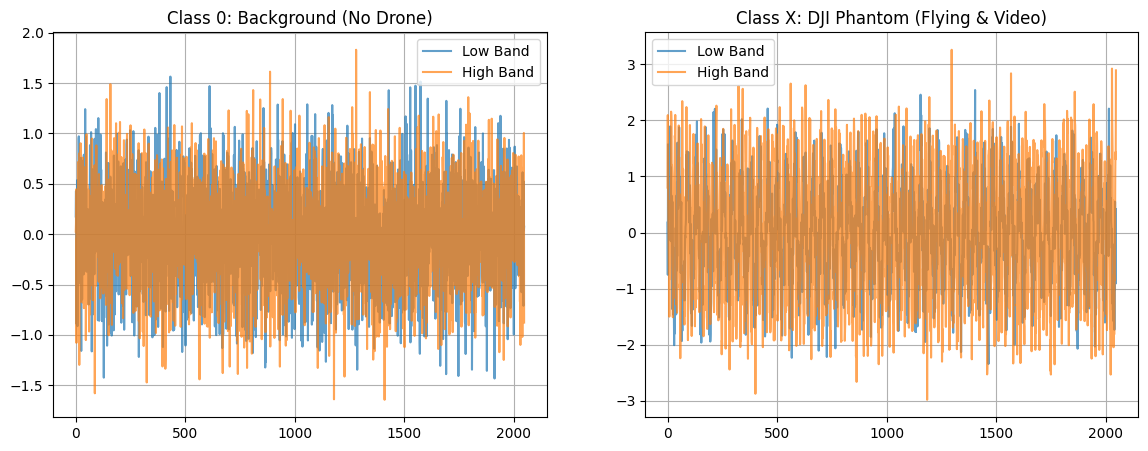

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 작은 데이터셋 구현
# 1. 2048개의 시간 스텝 생성 (AI 모델에 들어갈 한 덩어리의 데이터 길이)
time_steps = 2048
t = np.linspace(0, 1, time_steps)

# 2. 클래스 0: Background (드론 없음, 일상적인 노이즈 상태)
bg_low_band = np.random.normal(0, 0.5, time_steps)
bg_high_band = np.random.normal(0, 0.5, time_steps)

# 3. 클래스 3: DJI Phantom (비행 및 비디오 전송 중)
# 드론 모터와 영상 전송 통신파가 섞인 특정한 주파수(예: 사인파 형태)가 노이즈 위에 얹어집니다.
drone_low_band = np.sin(2 * np.pi * 50 * t) + np.random.normal(0, 0.5, time_steps)
drone_high_band = np.cos(2 * np.pi * 120 * t) * 1.5 + np.random.normal(0, 0.5, time_steps)

# 4. 시계열 그래프 그리기
plt.figure(figsize=(14, 5))

# --- Background 신호 (드론 없음) ---
plt.subplot(1, 2, 1)
plt.plot(bg_low_band, label='Low Band', alpha=0.7)
plt.plot(bg_high_band, label='High Band', alpha=0.7)
plt.title('Class 0: Background (No Drone)')
plt.legend()
plt.grid(True)

# --- DJI Phantom 신호 (비디오 전송 중) ---
plt.subplot(1, 2, 2)
plt.plot(drone_low_band, label='Low Band', alpha=0.7)
plt.plot(drone_high_band, label='High Band', alpha=0.7)
plt.title('Class X: DJI Phantom (Flying & Video)')
plt.legend()
plt.grid(True)

plt.show()

In [11]:
import torch

def apply_fft_preprocessing(time_series_data):
    # 입력 데이터 형태: (Batch, 2, 2048) - 2.4GHz 대역의 I/Q 또는 분할 밴드 신호

    # 1. 고속 푸리에 변환 (FFT) 수행
    # torch.fft.fft는 시간 축 데이터(dim=2)를 복소수 형태의 주파수 데이터로 변환합니다.
    fft_result = torch.fft.fft(time_series_data, dim=2)

    # 2. 주파수 스펙트럼의 크기(Magnitude) 추출
    # 복소수의 절대값을 취하여, 전파 에너지가 특정 주파수에 얼마나 집중되어 있는지 계산합니다.
    magnitude_spectrum = torch.abs(fft_result)

    # 3. 절반만 사용 (Nyquist 대칭성 활용)
    # 실수(Real) 신호를 FFT하면 결과의 절반은 데칼코마니처럼 대칭을 이룹니다.
    # 연산량을 줄이기 위해 절반(1024)만 잘라냅니다.
    half_length = magnitude_spectrum.shape[2] // 2
    useful_spectrum = magnitude_spectrum[:, :, :half_length]

    # 4. (옵션) Log 스케일 변환
    # 통신 신호 특성상 특정 주파수의 Peak 값이 비정상적으로 클 수 있습니다.
    # AI 학습 시 기울기 폭발(Gradient Exploding)을 막기 위해 로그 스케일로 압축해 줍니다.
    log_spectrum = torch.log1p(useful_spectrum)

    return log_spectrum

# 가상의 DroneRF 데이터 (배치 1, 2채널, 2048시간 스텝)
dummy_rf = torch.randn(1, 2, 2048)

# 전처리 함수 통과
processed_rf = apply_fft_preprocessing(dummy_rf)

print(f"변환 전(시간 축) 형태: {dummy_rf.shape}")
print(f"변환 후(주파수 축) 형태: {processed_rf.shape}")

print(2048//128)



#그러나, 해당 전처리 방식은 긴 시간(2048) 데이터를 한번에 뭉뚱그려 특징을 추출하므로, 어느 시점에 특정 이벤트가 발생했는지 알려주지 못 함

변환 전(시간 축) 형태: torch.Size([1, 2, 2048])
변환 후(주파수 축) 형태: torch.Size([1, 2, 1024])
64


In [8]:
import torch
import torch.nn as nn

class DroneRF_Detector(nn.Module):
    def __init__(self, num_classes=10): # 10개의 비행 모드 분류
        super(DroneRF_Detector, self).__init__()

        # 입력: (Batch, 2, 1024) -> 2개의 밴드, 1024 시간 스텝
        # 1. 넓은 필터로 빠르게 훑기 (Macro Feature)
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=16, stride=2, padding=7)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        # 통과 후 시간 길이: 1024 -> 128 으로 팍 줄어듦

        # 2. 미세한 특징 찾기 (Micro Feature)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, padding=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4)
        # 통과 후 시간 길이: 128 -> 31.75(=31)

        self.flatten = nn.Flatten()

        # 64(특징 개수) * 31(남은 시간 스텝)
        self.fc1 = nn.Linear(64*31, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        return self.fc2(x)

model = DroneRF_Detector(num_classes=10)
out = model(processed_rf)

print(f"입력 형태: {processed_rf.shape}")
print(f"출력 형태: {out.shape} -> (10개 클래스에 대한 확률 Logit)")

입력 형태: torch.Size([1, 2, 1024])
출력 형태: torch.Size([1, 10]) -> (10개 클래스에 대한 확률 Logit)


In [12]:
import torch

def apply_stft_preprocessing(time_series_data, n_fft=128, hop_length=64):
    # 입력 데이터: (Batch, Channels, Seq_Len) -> 예: (1, 2, 2048)
    batch_size, num_channels, seq_len = time_series_data.shape

    # 1. PyTorch의 STFT는 보통 2D (Batch, Time) 형태를 원하므로 채널과 배치를 하나로 합칩니다.
    flat_data = time_series_data.view(-1, seq_len) # (2, 2048)

    # 2. Hanning Window 생성 (신호가 뚝 끊겨서 발생하는 노이즈 방지용)
    window = torch.hann_window(n_fft).to(time_series_data.device)

    # 3. STFT 수행
    # n_fft: 창문의 크기 (128개의 데이터씩 묶어서 분석)
    # hop_length: 창문이 이동하는 보폭 (64칸씩 이동 -> 50% Overlap)
    stft_result = torch.stft(flat_data, n_fft=n_fft, hop_length=hop_length,
                             window=window, return_complex=True)

    # 4. 크기(Magnitude) 추출 및 Log 스케일 변환
    magnitude = torch.abs(stft_result)
    log_spectrogram = torch.log1p(magnitude)

    # 5. 원래의 (Batch, Channels, Freq_bins, Time_frames) 4차원 형태로 복구
    freq_bins, time_frames = log_spectrogram.shape[1], log_spectrogram.shape[2]
    spectrograms = log_spectrogram.view(batch_size, num_channels, freq_bins, time_frames)

    return spectrograms

# 가상의 DroneRF 데이터 통과 테스트
dummy_rf = torch.randn(1, 2, 2048)
processed_stft = apply_stft_preprocessing(dummy_rf)

print(f"STFT 변환 전(순수 시계열): {dummy_rf.shape}")
print(f"STFT 변환 후(스펙트로그램): {processed_stft.shape}")
# 출력 결과: (1, 2, 65, 33)
# -> 2개의 채널이 각각 높이(주파수) 65, 너비(시간) 33을 가진 2D 이미지 텐서로 변환됨!





#기존 FFT는 TIME WINDOW가 너무 큰 문제가 있었지만, STFT를 통해 WINDOW 범위를 줄여 TIME에 대한 정보를 이전보다 더 촘촘하게 얻을 수 있게 됨
#이후 33(시간)에 대한 65(주파수)개의 특징을 각각 뽑아내어, 기존 TIME-SEIRES MODEL에 시간 순서대로 집어 넣으면 됨(시간 흐름에 따른 주파수 흐름)

STFT 변환 전(순수 시계열): torch.Size([1, 2, 2048])
STFT 변환 후(스펙트로그램): torch.Size([1, 2, 65, 33])
